In [1]:
% matplotlib inline
from __future__ import (division,  
                        print_function)

import os
import sys
import copy
import glob
import fnmatch
import warnings

# Numpy & Scipy
import scipy
import numpy as np

# Astropy related
from astropy.io import fits 
from astropy import wcs
from astropy import units as u
from astropy.table import Table, Column, vstack, join
from astropy.stats import sigma_clip
from astropy.cosmology import FlatLambdaCDM as cosmo
cosmo = cosmo(H0=70, Om0=0.3)

# Matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

# AstroML
from astroML.plotting import hist

# Color map 
from palettable.colorbrewer.sequential import Oranges_4, Greens_4, Blues_5
ORG4 = Oranges_4.mpl_colormap
BLU5 = Blues_5.mpl_colormap
GRN4 = Greens_4.mpl_colormap

# Matplotlib default settings
rcdef = plt.rcParams.copy()
rcdef['figure.figsize'] = 12, 10
rcdef['xtick.major.size'] = 8.0
rcdef['xtick.major.width'] = 1.5
rcdef['xtick.minor.size'] = 4.0
rcdef['xtick.minor.width'] = 1.5
rcdef['ytick.major.size'] = 8.0
rcdef['ytick.major.width'] = 1.5
rcdef['ytick.minor.size'] = 4.0
rcdef['ytick.minor.width'] = 1.5
rcdef['legend.numpoints'] = 1
#rc('axes', linewidth=2)

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union
from shapely.prepared import prep
from descartes import PolygonPatch

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol
from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# GALEX pivot wavelength 
galex_fuv_pivot = 1535.0
galex_nuv_pivot = 2301.0

# WISE pivot wavelength 
wise_w1_pivot = 34000.0
wise_w2_pivot = 46000.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.155, 0.66
right          = left + width 
bottom, height = 0.13, 0.86
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

SBP1 = [0.13, 0.12, 0.865, 0.30]
SBP2 = [0.13, 0.42, 0.865, 0.54]

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

In [82]:
def simpleScatter(xarr, yarr, 
                  xtick=True, ytick=True,
                  xstr=None, ystr=None, titleUse=None, 
                  carr=None, sarr=None, 
                  cmap=ORG4, maxSize=350, alpha=0.8, 
                  ax=None, xylim=True, nolabel=False, 
                  titleSize=30, labelSize=36, 
                  xTickSize=32, yTickSize=32,
                  xFormat='$\mathrm{%g}$',
                  yFormat='$\mathrm{%g}$',
                  titleX=0.04, titleY=0.92, 
                  xmargin=7.5, ymargin=7.5, 
                  noEdge=True, colorUse='r', 
                  sizeUse=40, sizeUse2=60,
                  xarr2=None, yarr2=None, 
                  xmin=None, ymin=None, 
                  xmax=None, ymax=None, 
                  carr2=None, sarr2=None, 
                  cmap2=BLU5, alpha2=0.9, 
                  colorUse2='b', hline=None):
    #---------------------------------------------------------#
    if ax is None:
        fig = plt.figure(figsize=(12, 10))
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
        ax1 = fig.add_subplot(111)
    else:
        ax1 = ax

    # Formatting 
    ax1 = songPlotSetup(ax1, 
                        xlabel=xTickSize, ylabel=yTickSize, 
                        xtickFormat=xFormat, 
                        ytickFormat=yFormat)
    # Color Array 
    if carr is None:
        carr = colorUse
        
    if carr2 is None:
        carr2 = colorUse2
      
    # Size Array
    if sarr is None: 
        sarr = sizeUse
    else: 
        sarr = toSizeArr(sarr, maxSize=maxSize)
    if sarr2 is None: 
        sarr2 = sizeUse2
    else: 
        sarr2= toSizeArr(sarr2, maxSize=maxSize)
    
    # Scatter plot
    if noEdge:
        ax1.scatter(xarr, yarr, c=carr, s=sarr, 
                    alpha=alpha, cmap=cmap, edgecolor='none')
        if xarr2 is not None and yarr2 is not None: 
            ax1.scatter(xarr2, yarr2, c=carr2, s=sarr2, 
                        alpha=alpha2, cmap=cmap2, edgecolor='none')
            
    else:
        ax1.scatter(xarr, yarr, c=carr, s=sarr, 
                    alpha=alpha, cmap=cmap)
        if xarr2 is not None and yarr2 is not None: 
            ax1.scatter(xarr2, yarr2, c=carr2, s=sarr2, 
                        alpha=alpha2, cmap=cmap2)

    # Label
    if xstr is not None:
        ax1.set_xlabel(xstr, size=labelSize)
    if ystr is not None:
        ax1.set_ylabel(ystr, size=labelSize)

    # Axis limits
    if xylim:
        x0, x1 = np.nanmin(xarr), np.nanmax(xarr)
        y0, y1 = np.nanmin(yarr), np.nanmax(yarr)
        if xmin is None:
            xmin = x0
        if xmax is None: 
            xmax = x1
        if ymin is None:
            ymin = y0
        if ymax is None: 
            ymax = y1
        xmargin, ymargin = ((xmax - xmin) / xmargin), ((ymax - ymin) / ymargin)
        ax1.set_xlim(xmin-xmargin, xmax+xmargin)
        ax1.set_ylim(ymin-ymargin, ymax+ymargin)
        
    # Horizontal Line
    if hline is not None: 
        ax1.axhline(hline, linestyle='--', linewidth=6.0, 
                    color='k', alpha=0.6, zorder=0)

    # Title 
    if titleUse is not None:
        titleUse = titleUse.replace('_', '\_')
        ax1.text(titleX, titleY, '$\mathrm{%s}$' % titleUse, size=titleSize, 
                 transform = ax1.transAxes)
    #---------------------------------------------------------#
    if ax is None:
        return fig
    else: 
        return ax1
    
    
def qualityControl(inputTab, useY=True, strict=False, verbose=True, 
                   brightCenter=False, brightAny=False):
    """HSC basic quality"""
    table = copy.deepcopy(inputTab)
    nGal = len(table)
    
    outputTab = table[(table['if_countinputs'] > 1) &
                      (table['gf_countinputs'] > 1) &
                      (table['rf_countinputs'] > 1) &
                      (table['zf_countinputs'] > 1) &
                      (~table['ir_deblend_too_many_peaks']) &
                      (~table['if_shape_sdss_flags']) & 
                      (~table['if_centroid_naive_flags']) & 
                      (~table['if_centroid_sdss_flags_1']) & 
                      (~table['ir_deblend_as_psf']) &
                      (~table['gf_flags_pixel_edge']) &
                      (~table['rf_flags_pixel_edge']) &
                      (~table['if_flags_pixel_edge']) &
                      (~table['zf_flags_pixel_edge']) &
                      (~table['gf_cmodel_flux_flags']) &
                      (~table['rf_cmodel_flux_flags']) &
                      (~table['zf_cmodel_flux_flags']) &
                      (~table['gf_centroid_sdss_flags']) &
                      (~table['rf_centroid_sdss_flags']) &
                      (~table['zf_centroid_sdss_flags']) &
                      (~table['gf_flags_pixel_suspect_center']) &
                      (~table['rf_flags_pixel_suspect_center']) &
                      (~table['if_flags_pixel_suspect_center']) &
                      (~table['zf_flags_pixel_suspect_center']) &
                      (~table['gf_flags_pixel_saturated_center']) &
                      (~table['rf_flags_pixel_saturated_center']) &
                      (~table['zf_flags_pixel_saturated_center']) &
                      (~table['gf_flags_pixel_interpolated_center']) &
                      (~table['rf_flags_pixel_interpolated_center']) &
                      (~table['zf_flags_pixel_interpolated_center'])
                     ]
    
    if useY: 
        outputTab = outputTab[(np.isfinite(outputTab['ymag_cmodel'])) &
                              (outputTab['yf_countinputs'] > 1) &
                              (~outputTab['yf_flags_pixel_edge']) &
                              (~outputTab['yf_centroid_sdss_flags']) &
                              (~outputTab['yf_cmodel_flux_flags']) &
                              (~outputTab['yf_flags_pixel_suspect_center']) &
                              (~outputTab['yf_flags_pixel_saturated_center']) &
                              (~outputTab['yf_flags_pixel_interpolated_center'])
                             ]

    if strict:
        outputTab = outputTab[(~outputTab['gf_flags_pixel_clipped_any']) &
                              (~outputTab['rf_flags_pixel_clipped_any']) &
                              (~outputTab['if_flags_pixel_clipped_any']) &
                              (~outputTab['zf_flags_pixel_clipped_any']) &
                              (~outputTab['gf_flags_pixel_interpolated_any']) &
                              (~outputTab['rf_flags_pixel_interpolated_any']) &
                              (~outputTab['if_flags_pixel_interpolated_any']) &
                              (~outputTab['zf_flags_pixel_interpolated_any'])
                             ]
        if useY:
            outputTab = outputTab[(~outputTab['yf_flags_pixel_clipped_any']) &
                                  (~outputTab['yf_flags_pixel_interpolated_any'])
                                 ]
                                  
    if brightAny:
        outputTab = outputTab[~outputTab['if_flags_pixel_bright_object_any']]
    elif brightCenter:
        outputTab = outputTab[~outputTab['if_flags_pixel_bright_object_center']]
    
    if verbose:
        print("# %d / %d items left in the sample" % (len(outputTab), nGal))
    
    return outputTab 


def getRingColor(tab, ap1, ap2, filter1, filter2):
    flux1 = np.abs(tab[filter1 + 'flux_aperture0' + ap1] - 
                   tab[filter1 + 'flux_aperture0' + ap2])
    flux2 = np.abs(tab[filter2 + 'flux_aperture0' + ap1] - 
                   tab[filter2 + 'flux_aperture0' + ap2])
    return (2.5 * np.log10(flux2 / flux1))

# Check the Blue-Core AGN in HSC COSMOS_WIDE_DEPTH_MEDIAN_SEEING

## Prepare the catalog

### Aperture Photometry: 
    
* In HSC, we have 9 different apertures: 
    
| NAME       | R(pix) | R (arcsec) |
|:----------:|:------:|:----------:|
| aperture00 |  3.0   | 1.01 |
| aperture01 |  4.5   | 1.51 |
| aperture02 |  6.0   | 2.02 |
| aperture03 |  9.0   | 3.02 |
| aperture04 | 12.0   | 4.03 |
| aperture05 | 17.0   | 5.71 |
| aperture06 | 25.0   | 8.40 |
| aperture07 | 35.0   | 11.8 |
| aperture08 | 50.0   | 16.8 |
| aperture09 | 70.0   | 23.5 |

In [5]:
cat = Table.read('hscCosWideMedian_i23_agnMatched.fits', format='fits')
print("Number of objects : %d" % len(cat))

blueCore = cat[cat['BLUE_CORE'] > 0]
print("Number of blue core AGN : %d" % len(blueCore))

Number of objects : 62372
Number of blue core AGN : 45


### Clean the sample

In [92]:
clean = qualityControl(cat, strict=True)
clean.write('hscCosWideMedian_i23_agnMatched_clean.fits', format='fits',
            overwrite=True)

bright = clean[clean['imag_cmodel'] <= 21.0]
print("# %d objects are brighter than 21.0 mag (cmodel i-band)" % len(bright))

# 27424 / 62372 items left in the sample
# 4898 objects are brighter than 21.0 mag (cmodel i-band)


## Compare Photometry

### Magnitude-Color Relations:

#### cModel colors

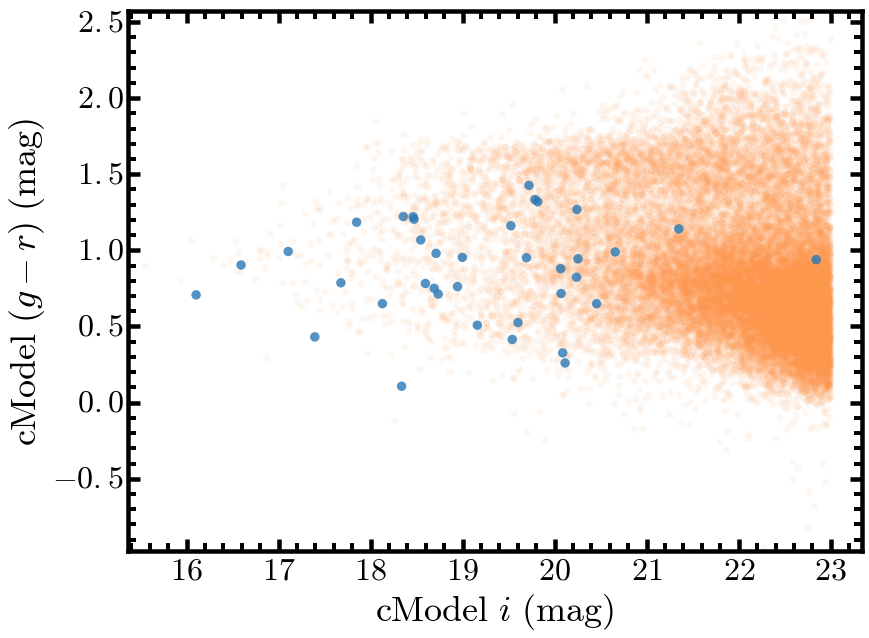

In [67]:
i_cmod_1 = clean['imag_cmodel']
gr_cmod_1 = (clean['gmag_cmodel'] - clean['rmag_cmodel'])

i_cmod_2 = blueCore['imag_cmodel']
gr_cmod_2 = (blueCore['gmag_cmodel'] - blueCore['rmag_cmodel'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$\mathrm{cModel}\ (g-r)\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, gr_cmod_1,  
                     xarr2=i_cmod_2, yarr2=gr_cmod_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.6, ymax=2.2,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

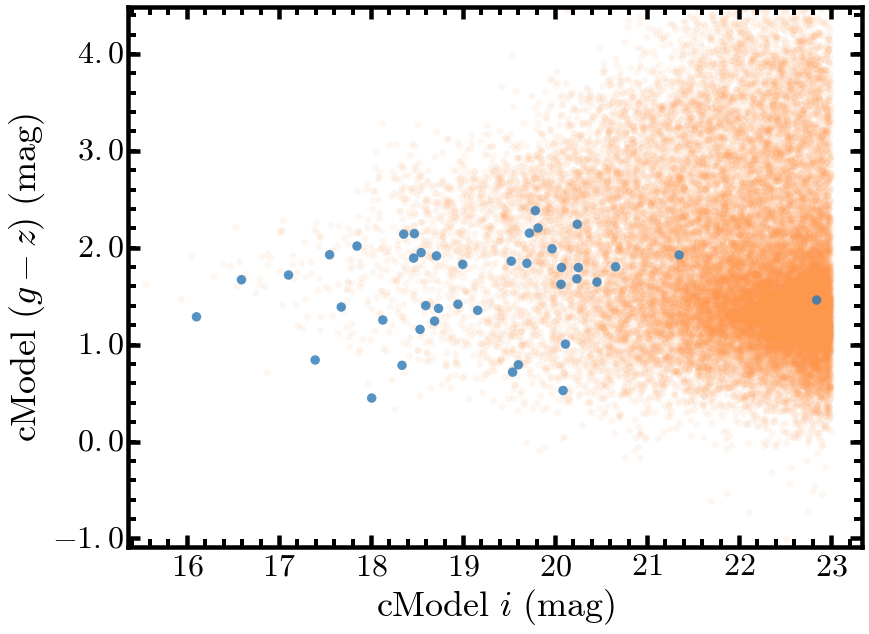

In [75]:
i_cmod_1 = clean['imag_cmodel']
gz_cmod_1 = (clean['gmag_cmodel'] - clean['zmag_cmodel'])

i_cmod_2 = blueCore['imag_cmodel']
gz_cmod_2 = (blueCore['gmag_cmodel'] - blueCore['zmag_cmodel'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$\mathrm{cModel}\ (g-z)\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, gz_cmod_1,  
                     xarr2=i_cmod_2, yarr2=gz_cmod_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.5, ymax=3.9,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

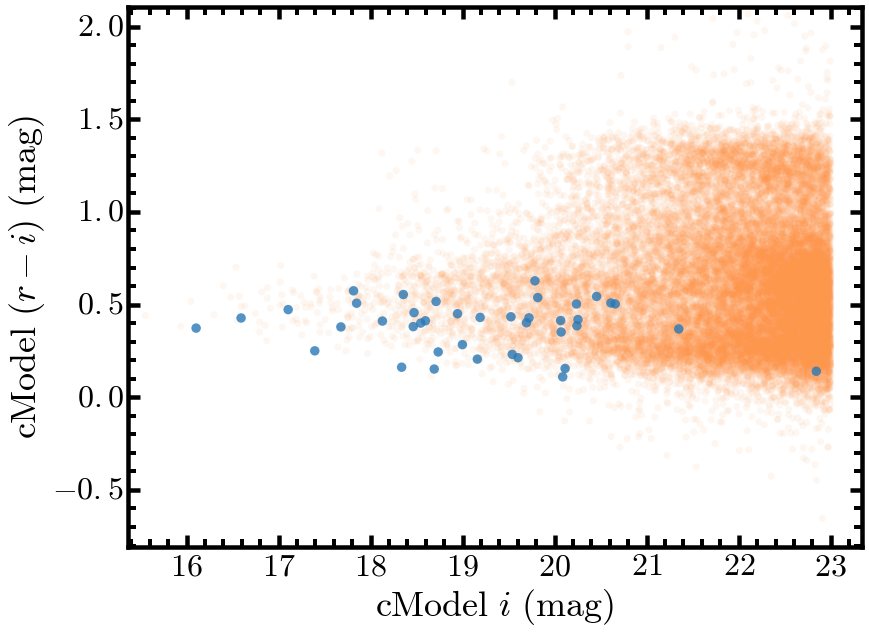

In [66]:
i_cmod_1 = clean['imag_cmodel']
ri_cmod_1 = (clean['rmag_cmodel'] - clean['imag_cmodel'])
#yarr1 = (clean['rmag_psf'] - clean['imag_psf']) - (clean['rmag_kron'] - clean['imag_kron'])

i_cmod_2 = blueCore['imag_cmodel']
ri_cmod_2 = (blueCore['rmag_cmodel'] - blueCore['imag_cmodel'])
#yarr2 = (blueCore['rmag_psf'] - blueCore['imag_psf']) - (blueCore['rmag_kron'] - blueCore['imag_kron'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$\mathrm{cModel}\ (r-i)\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, ri_cmod_1,  
                     xarr2=i_cmod_2, yarr2=ri_cmod_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.5, ymax=1.8, 
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

#### PSF color

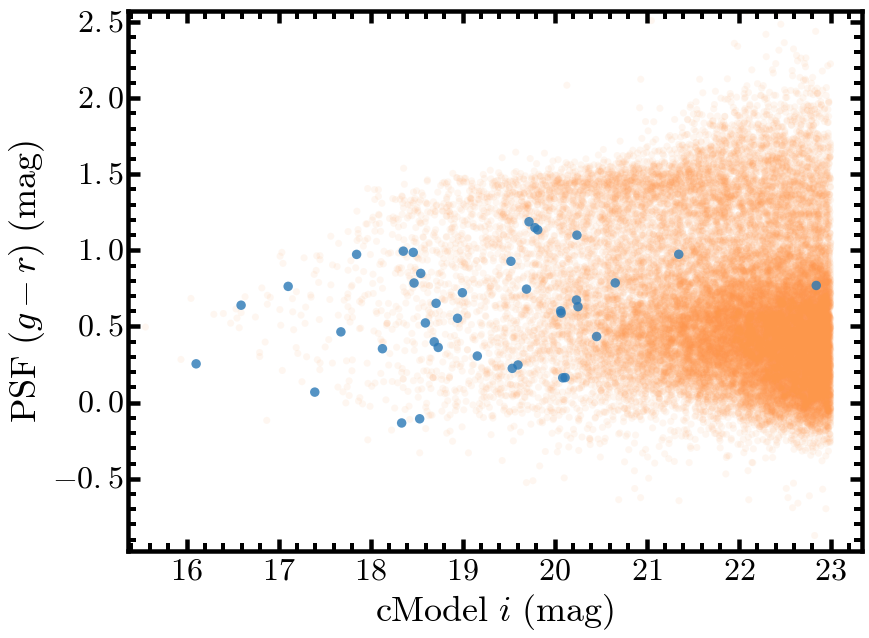

In [76]:
i_cmod_1 = clean['imag_cmodel']
gr_psf_1 = (clean['gmag_psf'] - clean['rmag_psf'])

i_cmod_2 = blueCore['imag_cmodel']
gr_psf_2 = (blueCore['gmag_psf'] - blueCore['rmag_psf'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$\mathrm{PSF}\ (g-r)\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, gr_psf_1,  
                     xarr2=i_cmod_2, yarr2=gr_psf_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.6, ymax=2.2,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

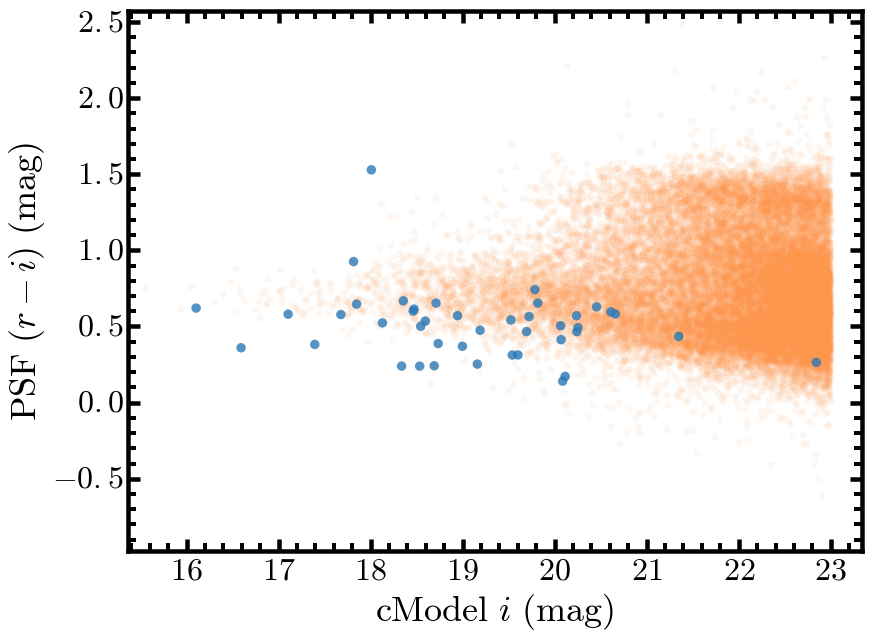

In [77]:
i_cmod_1 = clean['imag_cmodel']
ri_psf_1 = (clean['rmag_psf'] - clean['imag_psf'])

i_cmod_2 = blueCore['imag_cmodel']
ri_psf_2 = (blueCore['rmag_psf'] - blueCore['imag_psf'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$\mathrm{PSF}\ (r-i)\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, ri_psf_1,  
                     xarr2=i_cmod_2, yarr2=ri_psf_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.6, ymax=2.2,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

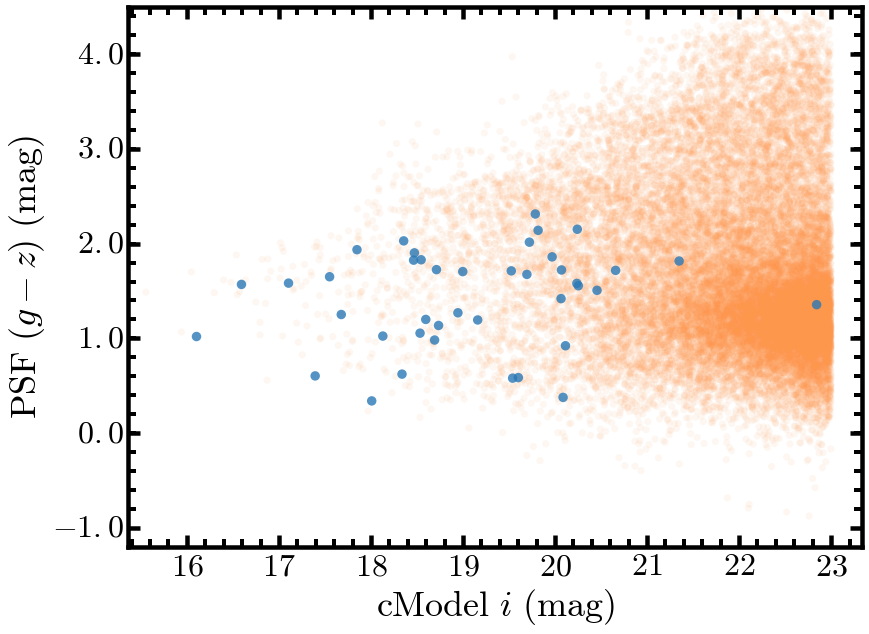

In [78]:
i_cmod_1 = clean['imag_cmodel']
gz_psf_1 = (clean['gmag_psf'] - clean['zmag_psf'])

i_cmod_2 = blueCore['imag_cmodel']
gz_psf_2 = (blueCore['gmag_psf'] - blueCore['zmag_psf'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$\mathrm{PSF}\ (g-z)\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, gz_psf_1,  
                     xarr2=i_cmod_2, yarr2=gz_psf_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.6, ymax=3.9,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

### Magnitude - Color Difference & cModel Color v.s. Color Difference

* For color-$\Delta$(color) plot, only the object with imag_cmodel <= 21.0 are included

#### cModel mag v.s. (PSF - cModel) Color

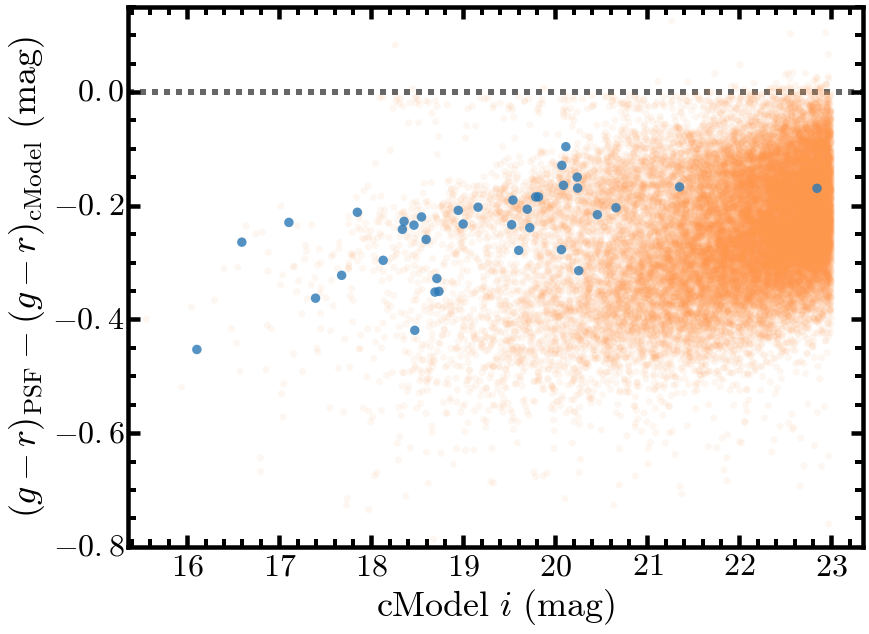

In [83]:
i_cmod_1 = clean['imag_cmodel']
dgrA_1 = (clean['gmag_psf'] - clean['rmag_psf']) - (clean['gmag_cmodel'] - clean['rmag_cmodel'])

i_cmod_2 = blueCore['imag_cmodel']
dgrA_2 = (blueCore['gmag_psf'] - blueCore['rmag_psf']) - (blueCore['gmag_cmodel'] - blueCore['rmag_cmodel'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(g-r)_{\mathrm{PSF}} - (g-r)_{\mathrm{cModel}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, dgrA_1,  
                     xarr2=i_cmod_2, yarr2=dgrA_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.7, ymax=0.05, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

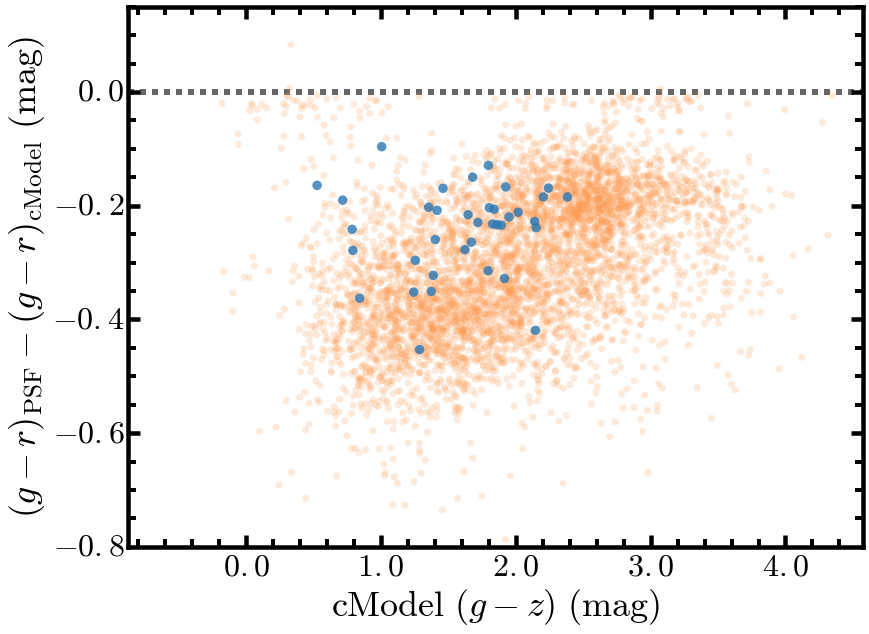

In [94]:
gz_cmod_1b = (bright['gmag_cmodel'] - bright['zmag_cmodel'])
dgrA_1b = (bright['gmag_psf'] - bright['rmag_psf']) - (bright['gmag_cmodel'] - bright['rmag_cmodel'])

xstr = '$\mathrm{cModel}\ (g-z)\ \mathrm{(mag)}$'
ystr = '$(g-r)_{\mathrm{PSF}} - (g-r)_{\mathrm{cModel}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(gz_cmod_1b, dgrA_1b,  
                     xarr2=gz_cmod_2, yarr2=dgrA_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.20, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=-0.3, xmax=4.0, 
                     ymin=-0.7, ymax=0.05, hline=0.0,
                     xFormat='$\mathrm{%3.1f}$', yFormat='$\mathrm{%3.1f}$')

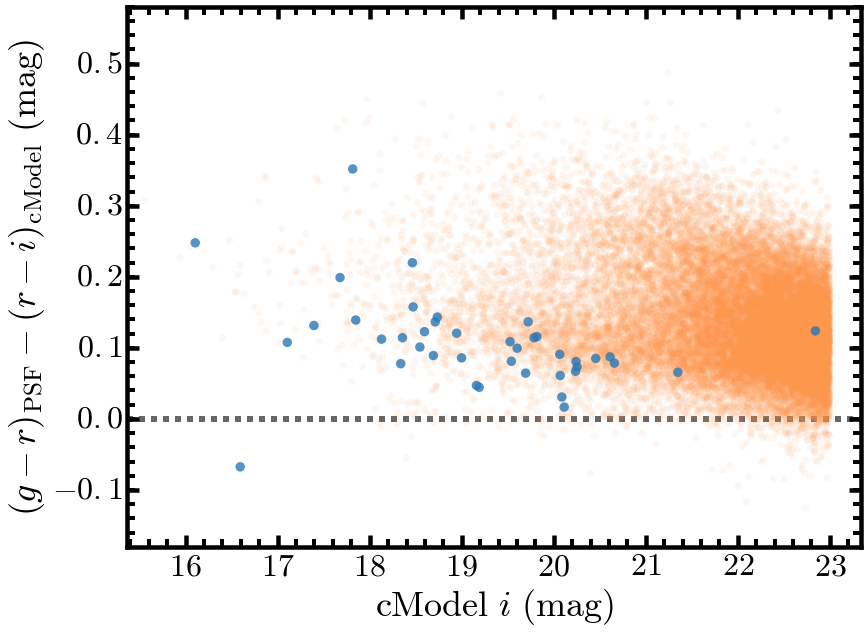

In [86]:
i_cmod_1 = clean['imag_cmodel']
driA_1 = (clean['rmag_psf'] - clean['imag_psf']) - (clean['rmag_cmodel'] - clean['imag_cmodel'])

i_cmod_2 = blueCore['imag_cmodel']
driA_2 = (blueCore['rmag_psf'] - blueCore['imag_psf']) - (blueCore['rmag_cmodel'] - blueCore['imag_cmodel'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{PSF}} - (r-i)_{\mathrm{cModel}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, driA_1,  
                     xarr2=i_cmod_2, yarr2=driA_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.1, ymax=0.5, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

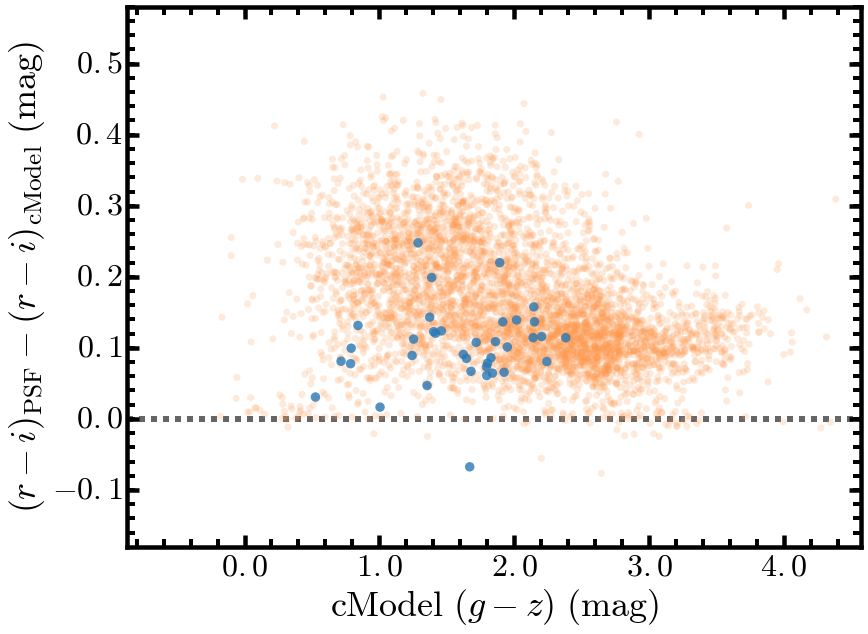

In [97]:
driA_1b = (bright['rmag_psf'] - bright['imag_psf']) - (bright['rmag_cmodel'] - bright['imag_cmodel'])

xstr = '$\mathrm{cModel}\ (g-z)\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{PSF}} - (r-i)_{\mathrm{cModel}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(gz_cmod_1b, driA_1b,  
                     xarr2=gz_cmod_2, yarr2=driA_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.20, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=-0.3, xmax=4.0, 
                     ymin=-0.1, ymax=0.5, hline=0.0,
                     xFormat='$\mathrm{%3.1f}$', yFormat='$\mathrm{%3.1f}$')

#### Using Kron magnitude 

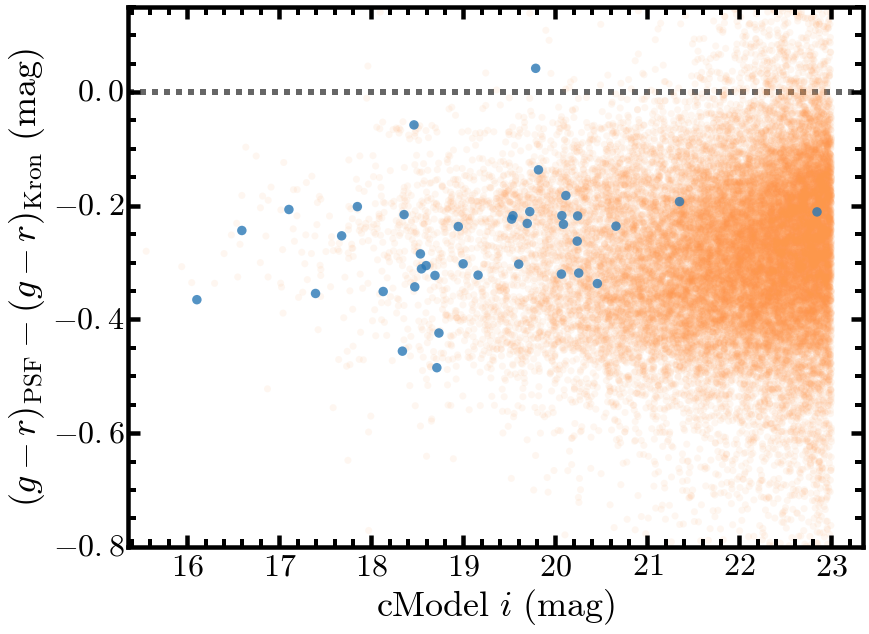

In [111]:
dgrB_1 = (clean['gmag_psf'] - clean['rmag_psf']) - (clean['gmag_kron'] - clean['rmag_kron'])
dgrB_2 = (blueCore['gmag_psf'] - blueCore['rmag_psf']) - (blueCore['gmag_kron'] - blueCore['rmag_kron'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(g-r)_{\mathrm{PSF}} - (g-r)_{\mathrm{Kron}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, dgrB_1,  
                     xarr2=i_cmod_2, yarr2=dgrB_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.7, ymax=0.05, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

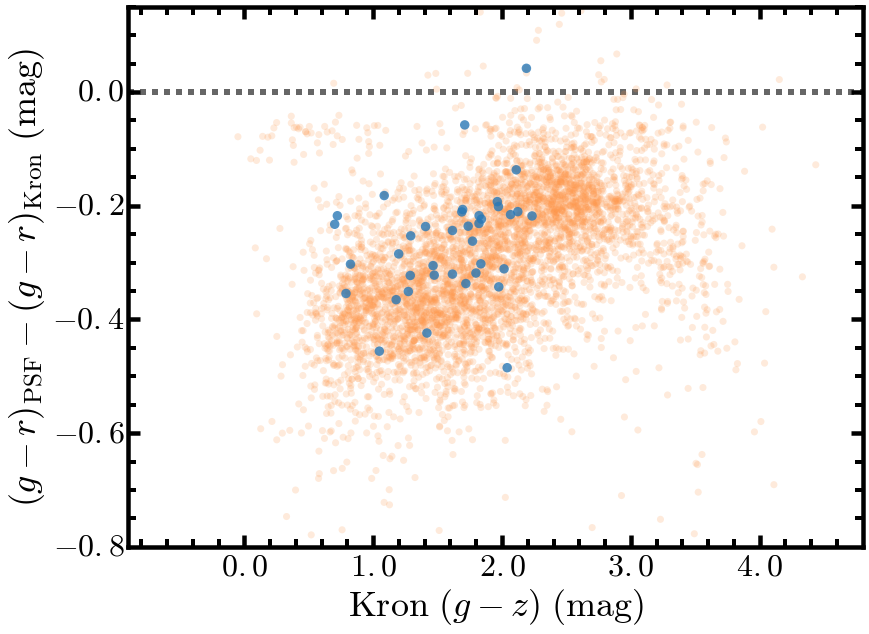

In [118]:
gz_kron_1b = (bright['gmag_kron'] - bright['zmag_kron'])
dgrB_1b = (bright['gmag_psf'] - bright['rmag_psf']) - (bright['gmag_kron'] - bright['rmag_kron'])

gz_kron_2 = (blueCore['gmag_kron'] - blueCore['zmag_kron'])

xstr = '$\mathrm{Kron}\ (g-z)\ \mathrm{(mag)}$'
ystr = '$(g-r)_{\mathrm{PSF}} - (g-r)_{\mathrm{Kron}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(gz_kron_1b, dgrB_1b,  
                     xarr2=gz_kron_2, yarr2=dgrB_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.20, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=-0.3, xmax=4.2, 
                     ymin=-0.7, ymax=0.05, hline=0.0,
                     xFormat='$\mathrm{%3.1f}$', yFormat='$\mathrm{%3.1f}$')

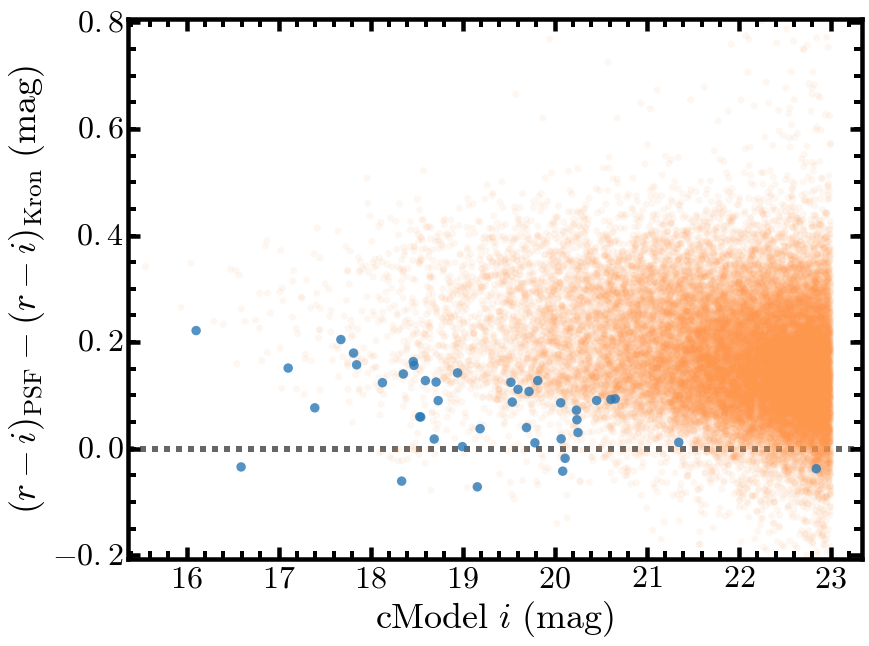

In [113]:
driB_1 = (clean['rmag_psf'] - clean['imag_psf']) - (clean['rmag_kron'] - clean['imag_kron'])
driB_2 = (blueCore['rmag_psf'] - blueCore['imag_psf']) - (blueCore['rmag_kron'] - blueCore['imag_kron'])

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{PSF}} - (r-i)_{\mathrm{Kron}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, driB_1,  
                     xarr2=i_cmod_2, yarr2=driB_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.1, ymax=0.7, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

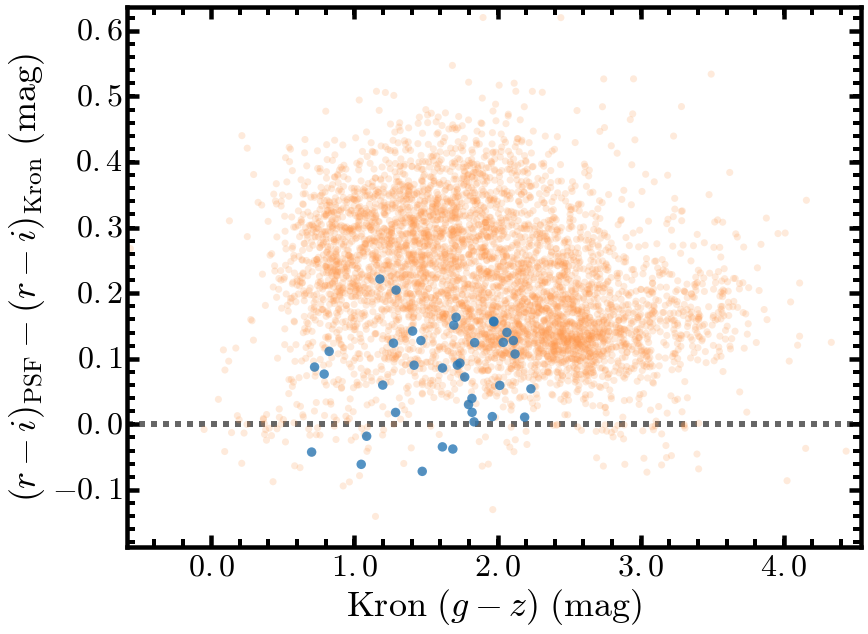

In [122]:
driB_1b = (bright['rmag_psf'] - bright['imag_psf']) - (bright['rmag_kron'] - bright['imag_kron'])

xstr = '$\mathrm{Kron}\ (g-z)\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{PSF}} - (r-i)_{\mathrm{Kron}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(gz_kron_1b, driB_1b,  
                     xarr2=gz_kron_2, yarr2=driB_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.20, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=-0.05, xmax=4.0, 
                     ymin=-0.1, ymax=0.55, hline=0.0,
                     xFormat='$\mathrm{%3.1f}$', yFormat='$\mathrm{%3.1f}$')

#### Using Color Difference between difference apertures

In [123]:
# Color within 1.0 arcsec
gr_ap0_1 = (clean['gmag_aperture00'] - clean['rmag_aperture00'])
gr_ap0_1b = (bright['gmag_aperture00'] - bright['rmag_aperture00'])
gr_ap0_2 = (blueCore['gmag_aperture00'] - blueCore['rmag_aperture00'])

ri_ap0_1 = (clean['rmag_aperture00'] - clean['imag_aperture00'])
ri_ap0_1b = (bright['rmag_aperture00'] - bright['imag_aperture00'])
ri_ap0_2 = (blueCore['rmag_aperture00'] - blueCore['imag_aperture00'])

gz_ap0_1 = (clean['gmag_aperture00'] - clean['zmag_aperture00'])
gz_ap0_1b = (bright['gmag_aperture00'] - bright['zmag_aperture00'])
gz_ap0_2 = (blueCore['gmag_aperture00'] - blueCore['zmag_aperture00'])

# Color within 1.5 arcsec
gr_ap1_1 = (clean['gmag_aperture01'] - clean['rmag_aperture01'])
gr_ap1_1b = (bright['gmag_aperture01'] - bright['rmag_aperture01'])
gr_ap1_2 = (blueCore['gmag_aperture01'] - blueCore['rmag_aperture01'])

ri_ap1_1 = (clean['rmag_aperture01'] - clean['imag_aperture01'])
ri_ap1_1b = (bright['rmag_aperture01'] - bright['imag_aperture01'])
ri_ap1_2 = (blueCore['rmag_aperture01'] - blueCore['imag_aperture01'])

gz_ap1_1 = (clean['gmag_aperture01'] - clean['zmag_aperture01'])
gz_ap1_1b = (bright['gmag_aperture01'] - bright['zmag_aperture01'])
gz_ap1_2 = (blueCore['gmag_aperture01'] - blueCore['zmag_aperture01'])

# Color within 2.2 arcsec
gr_ap2_1 = (clean['gmag_aperture02'] - clean['rmag_aperture02'])
gr_ap2_1b = (bright['gmag_aperture02'] - bright['rmag_aperture02'])
gr_ap2_2 = (blueCore['gmag_aperture02'] - blueCore['rmag_aperture02'])

ri_ap2_1 = (clean['rmag_aperture02'] - clean['imag_aperture02'])
ri_ap2_1b = (bright['rmag_aperture02'] - bright['imag_aperture02'])
ri_ap2_2 = (blueCore['rmag_aperture02'] - blueCore['imag_aperture02'])

gz_ap2_1 = (clean['gmag_aperture02'] - clean['zmag_aperture02'])
gz_ap2_1b = (bright['gmag_aperture02'] - bright['zmag_aperture02'])
gz_ap2_2 = (blueCore['gmag_aperture02'] - blueCore['zmag_aperture02'])

In [145]:
# Color within the ring between 16 and 3 arcsec 
gr_ap83_1 = getRingColor(clean, '8', '3', 'g', 'r')
gr_ap83_1b = getRingColor(bright, '8', '3', 'g', 'r')
gr_ap83_2 = getRingColor(blueCore, '8', '3', 'g', 'r')

ri_ap83_1 = getRingColor(clean, '8', '3', 'r', 'i')
ri_ap83_1b = getRingColor(bright, '8', '3', 'r', 'i')
ri_ap83_2 = getRingColor(blueCore, '8', '3', 'r', 'i')

gz_ap83_1 = getRingColor(clean, '8', '3', 'g', 'z')
gz_ap83_1b = getRingColor(bright, '8', '3', 'g', 'z')
gz_ap83_2 = getRingColor(blueCore, '8', '3', 'g', 'z')

# Color within the ring between 16 and 3 arcsec 
gr_ap73_1 = getRingColor(clean, '7', '3', 'g', 'r')
gr_ap73_1b = getRingColor(bright, '7', '3', 'g', 'r')
gr_ap73_2 = getRingColor(blueCore, '7', '3', 'g', 'r')

ri_ap73_1 = getRingColor(clean, '7', '3', 'r', 'i')
ri_ap73_1b = getRingColor(bright, '7', '3', 'r', 'i')
ri_ap73_2 = getRingColor(blueCore, '7', '3', 'r', 'i')

gz_ap73_1 = getRingColor(clean, '7', '3', 'g', 'z')
gz_ap73_1b = getRingColor(bright, '7', '3', 'g', 'z')
gz_ap73_2 = getRingColor(blueCore, '7', '3', 'g', 'z')

# Color within the ring between 8 and 2 arcsec 
gr_ap62_1 = getRingColor(clean, '6', '2', 'g', 'r')
gr_ap62_1b = getRingColor(bright, '6', '2', 'g', 'r')
gr_ap62_2 = getRingColor(blueCore, '6', '2', 'g', 'r')

ri_ap62_1 = getRingColor(clean, '6', '2', 'r', 'i')
ri_ap62_1b = getRingColor(bright, '6', '2', 'r', 'i')
ri_ap62_2 = getRingColor(blueCore, '6', '2', 'r', 'i')

gz_ap62_1 = getRingColor(clean, '6', '2', 'g', 'z')
gz_ap62_1b = getRingColor(bright, '6', '2', 'g', 'z')
gz_ap62_2 = getRingColor(blueCore, '6', '2', 'g', 'z')

/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:184: RuntimeWarning: divide by zero encountered in log10


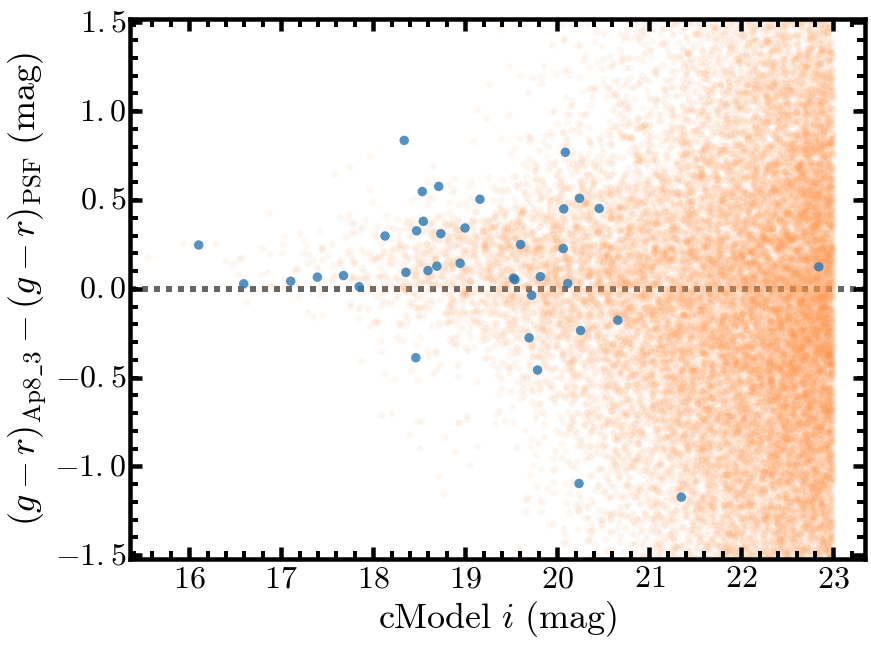

In [137]:
dgrAp1_1 = (gr_ap83_1 - gr_psf_1)
dgrAp1_2 = (gr_ap83_2 - gr_psf_2)

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(g-r)_{\mathrm{Ap8\_3}} - (g-r)_{\mathrm{PSF}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, dgrAp1_1,  
                     xarr2=i_cmod_2, yarr2=dgrAp1_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-1.2, ymax=1.2, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

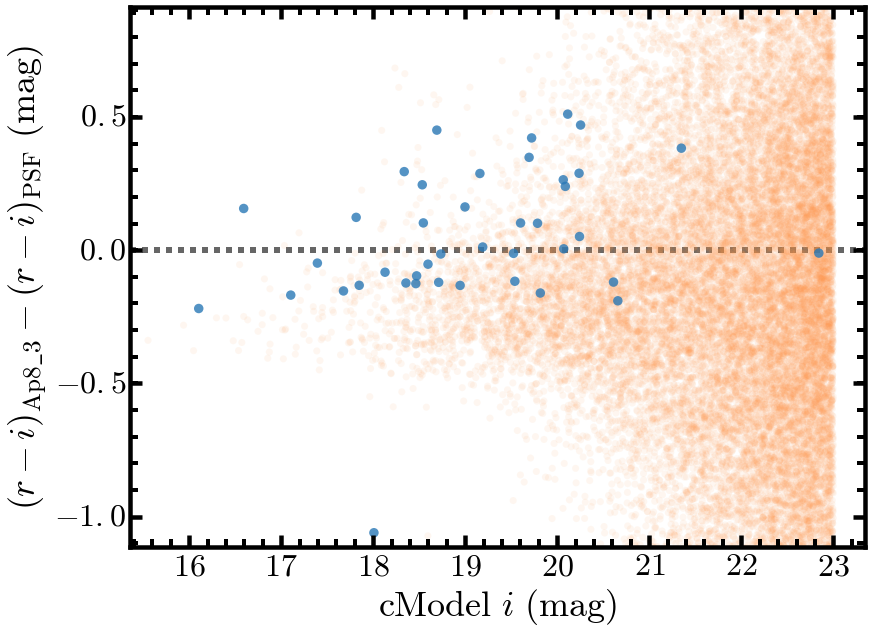

In [139]:
driAp1_1 = (ri_ap83_1 - ri_psf_1)
driAp1_2 = (ri_ap83_2 - ri_psf_2)

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{Ap8\_3}} - (r-i)_{\mathrm{PSF}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, driAp1_1,  
                     xarr2=i_cmod_2, yarr2=driAp1_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.9, ymax=0.7, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

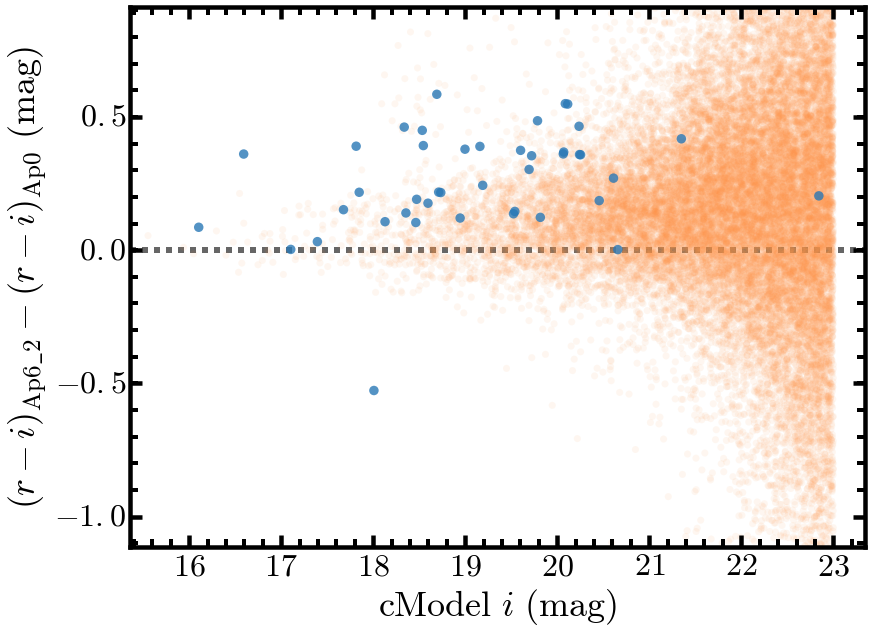

In [148]:
driAp2_1 = (ri_ap62_1 - ri_ap0_1)
driAp2_2 = (ri_ap62_2 - ri_ap0_2)

xstr = '$\mathrm{cModel}\ i\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{Ap6\_2}} - (r-i)_{\mathrm{Ap0}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(i_cmod_1, driAp2_1,  
                     xarr2=i_cmod_2, yarr2=driAp2_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.08, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=16.2, xmax=22.5, 
                     ymin=-0.9, ymax=0.7, hline=0.0,
                     xFormat='$\mathrm{%d}$', yFormat='$\mathrm{%3.1f}$')

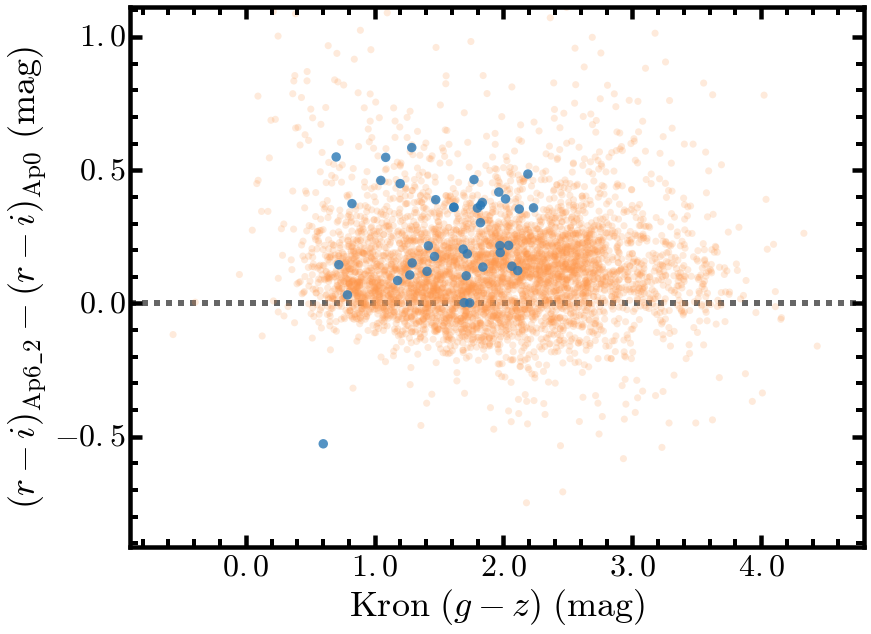

In [154]:
gz_kron_1b = (bright['gmag_kron'] - bright['zmag_kron'])
gz_kron_2 = (blueCore['gmag_kron'] - blueCore['zmag_kron'])

driAp2_1b = (ri_ap62_1b - ri_ap0_1b)

xstr = '$\mathrm{Kron}\ (g-z)\ \mathrm{(mag)}$'
ystr = '$(r-i)_{\mathrm{Ap6\_2}} - (r-i)_{\mathrm{Ap0}}\ \mathrm{(mag)}$'

fig1 = simpleScatter(gz_kron_1b, driAp2_1b,  
                     xarr2=gz_kron_2, yarr2=driAp2_2,
                     xstr=xstr, ystr=ystr,
                     alpha=0.20, alpha2=0.8,
                     sizeUse=50, sizeUse2=90,
                     colorUse=ORG4(0.6), colorUse2=BLU5(0.8),
                     xmin=-0.3, xmax=4.2, 
                     ymin=-0.7, ymax=0.9, hline=0.0,
                     xFormat='$\mathrm{%3.1f}$', yFormat='$\mathrm{%3.1f}$')